In [287]:
import catboost
!pip install imblearn
!pip install phik
!pip install lightgbm
!pip install xgboost
!pip install optuna
!pip install catboost

# Import Libraries

In [342]:
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from phik.report import plot_correlation_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer,plot_confusion_matrix
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import roc_curve, roc_auc_score,accuracy_score,precision_score,recall_score
import catboost as cb
import optuna
warnings.filterwarnings('ignore')
random_seed=12345
%matplotlib inline
plt.rcParams['figure.figsize']=16,8

In [289]:
random_seed=12345

# Read data

In [378]:
train=pd.read_csv('./data/train.csv')
test=pd.read_csv('./data/test.csv')

In [291]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [292]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30000 non-null  int64  
 1   age          30000 non-null  int64  
 2   gender       30000 non-null  int64  
 3   height       30000 non-null  int64  
 4   weight       30000 non-null  float64
 5   ap_hi        30000 non-null  int64  
 6   ap_lo        30000 non-null  int64  
 7   cholesterol  30000 non-null  int64  
 8   gluc         30000 non-null  int64  
 9   smoke        30000 non-null  int64  
 10  alco         30000 non-null  int64  
 11  active       30000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 2.7 MB


In [293]:
train.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [294]:
test.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


# EDA

In [295]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


In [296]:
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


Переведем признак age в года

In [297]:
train['age']=train['age']/365
test['age']=test['age']/365

Дропнем бесполезный признак id

In [379]:
train = train.drop(columns=['id'])
# feature_test = test.drop(columns=['id'])

In [299]:
train['gender'].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

In [300]:
categorical_features=['cholesterol', 'gluc', 'smoke', 'alco', 'active']
numeric_features=['age', 'height', 'weight', 'ap_hi', 'ap_lo']

In [301]:
train[numeric_features].describe()

,age,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.339358,164.359229,74.205690,128.817286,96.630414
std,6.759594,8.210126,14.395757,154.011419,188.472530
min,29.583562,55.000000,10.000000,-150.000000,-70.000000
25%,48.394521,159.000000,65.000000,120.000000,80.000000
50%,53.980822,165.000000,72.000000,120.000000,80.000000
75%,58.430137,170.000000,82.000000,140.000000,90.000000
max,64.967123,250.000000,200.000000,16020.000000,11000.000000


Как видно из описательной статистики имеются некорректные значения практически во всех столбцах

In [302]:
train[train['ap_hi']<0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4607,41.865753,1,165,78.0,-100,80,2,1,0,0,1,0
16021,60.569863,2,161,90.0,-115,70,1,1,0,0,1,0
20536,42.687671,1,153,54.0,-100,70,1,1,0,0,1,0
23988,50.139726,1,162,74.0,-140,90,1,1,0,0,1,1
25240,40.304110,2,168,50.0,-120,80,2,1,0,0,0,1
35040,63.904110,2,168,59.0,-150,80,1,1,0,0,1,1
46627,64.783562,2,160,59.0,-120,80,1,1,0,0,0,0


In [303]:
train[train['ap_lo']<0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
60106,61.838356,1,167,74.0,15,-70,1,1,0,0,1,1


Отрицательных значений мало, можем спокойно дропнуть

In [304]:
train=train.loc[(train['ap_hi']>0)]
train=train.loc[(train['ap_lo']>0)]

In [305]:
train['ap_lo'].describe()

count    69971.000000
mean        96.663603
std        188.502998
min          1.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      11000.000000
Name: ap_lo, dtype: float64

Посмотрим 99% и 1% квантили

In [306]:
train.quantile(.01)

age             39.632877
gender           1.000000
height         147.000000
weight          48.000000
ap_hi           90.000000
ap_lo           60.000000
cholesterol      1.000000
gluc             1.000000
smoke            0.000000
alco             0.000000
active           0.000000
cardio           0.000000
Name: 0.01, dtype: float64

In [307]:
train.quantile(.99)

age              64.351507
gender            2.000000
height          184.000000
weight          117.000000
ap_hi           180.000000
ap_lo          1000.000000
cholesterol       3.000000
gluc              3.000000
smoke             1.000000
alco              1.000000
active            1.000000
cardio            1.000000
Name: 0.99, dtype: float64

In [308]:
def quantile(df,col):
    return df[col].quantile(.01),df[col].quantile(.99)

In [309]:
cols = ['height','weight']

In [310]:
for col in cols:
    train=train.loc[train[col]>quantile(train,col)[0]]

In [311]:
train.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000,68384.000000
mean,53.332382,1.355609,164.758832,74.620943,128.926679,96.839407,1.367089,1.227319,0.089363,0.054355,0.803390,0.501769
std,6.746775,0.478701,7.564972,14.055832,155.598219,190.039942,0.680663,0.573372,0.285269,0.226718,0.397438,0.500001
min,29.583562,1.000000,148.000000,49.000000,1.000000,6.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.402740,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.972603,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,58.408219,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.967123,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Удалим выбросы по ад

In [312]:
train=train.loc[train['ap_hi']>60]
train=train.loc[train['ap_lo']>40]
train=train.loc[train['ap_hi']<300]
train=train.loc[train['ap_lo']<250]

In [313]:
train=train.loc[train['ap_hi']>train['ap_lo']]

In [314]:
train=train[train['height']<200]

In [315]:
train[train['weight']>140]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
338,57.747945,1,157,142.0,120,80,1,1,0,0,1,1
389,45.802740,2,165,169.0,120,80,1,1,0,0,1,0
435,45.931507,1,186,200.0,130,70,1,1,0,0,0,0
1270,52.115068,2,175,150.0,180,120,2,1,0,1,1,1
1598,44.134247,1,160,150.0,120,80,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
65005,57.742466,1,176,154.0,140,80,1,1,0,0,1,1
65418,49.978082,1,165,150.0,175,100,3,3,0,0,1,1
66832,49.630137,2,180,145.0,130,90,1,1,0,0,1,0
67435,50.131507,2,190,147.0,150,90,1,2,0,1,1,1


Довольно странно видеть людей с ожирением и нормальным ад, дропнем эти строки (попозже)

In [316]:
train.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67092.000000,67092.000000,67092.000000,67092.000000,67092.000000,67092.000000,67092.000000,67092.00000,67092.000000,67092.000000,67092.000000,67092.000000
mean,53.320551,1.354767,164.757855,74.532146,126.780436,81.385053,1.364768,1.22648,0.089191,0.053911,0.803061,0.496706
std,6.749637,0.478446,7.541982,13.989192,16.599004,9.386415,0.679201,0.57258,0.285021,0.225844,0.397688,0.499993
min,29.583562,1.000000,148.000000,49.000000,70.000000,45.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000
25%,48.386301,1.000000,160.000000,65.000000,120.000000,80.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.000000
50%,53.967123,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.00000,0.000000,0.000000,1.000000,0.000000
75%,58.402740,2.000000,170.000000,82.000000,140.000000,90.000000,1.000000,1.00000,0.000000,0.000000,1.000000,1.000000
max,64.967123,2.000000,198.000000,200.000000,240.000000,182.000000,3.000000,3.00000,1.000000,1.000000,1.000000,1.000000


In [317]:
train[numeric_features].corr()

,age,height,weight,ap_hi,ap_lo
age,1.000000,-0.084415,0.054235,0.206111,0.154276
height,-0.084415,1.000000,0.289839,0.014710,0.029981
weight,0.054235,0.289839,1.000000,0.264746,0.246529
ap_hi,0.206111,0.014710,0.264746,1.000000,0.734019
ap_lo,0.154276,0.029981,0.246529,0.734019,1.000000


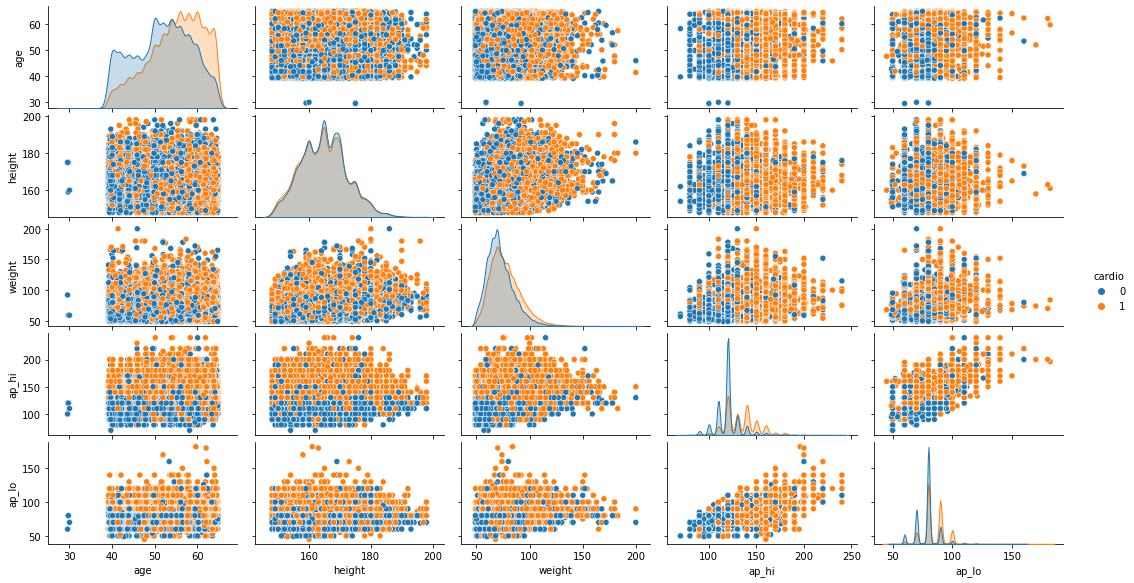

In [318]:
sns.pairplot(train, vars=numeric_features, hue='cardio').fig.set_size_inches(16,8)

interval columns not set, guessing: ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']


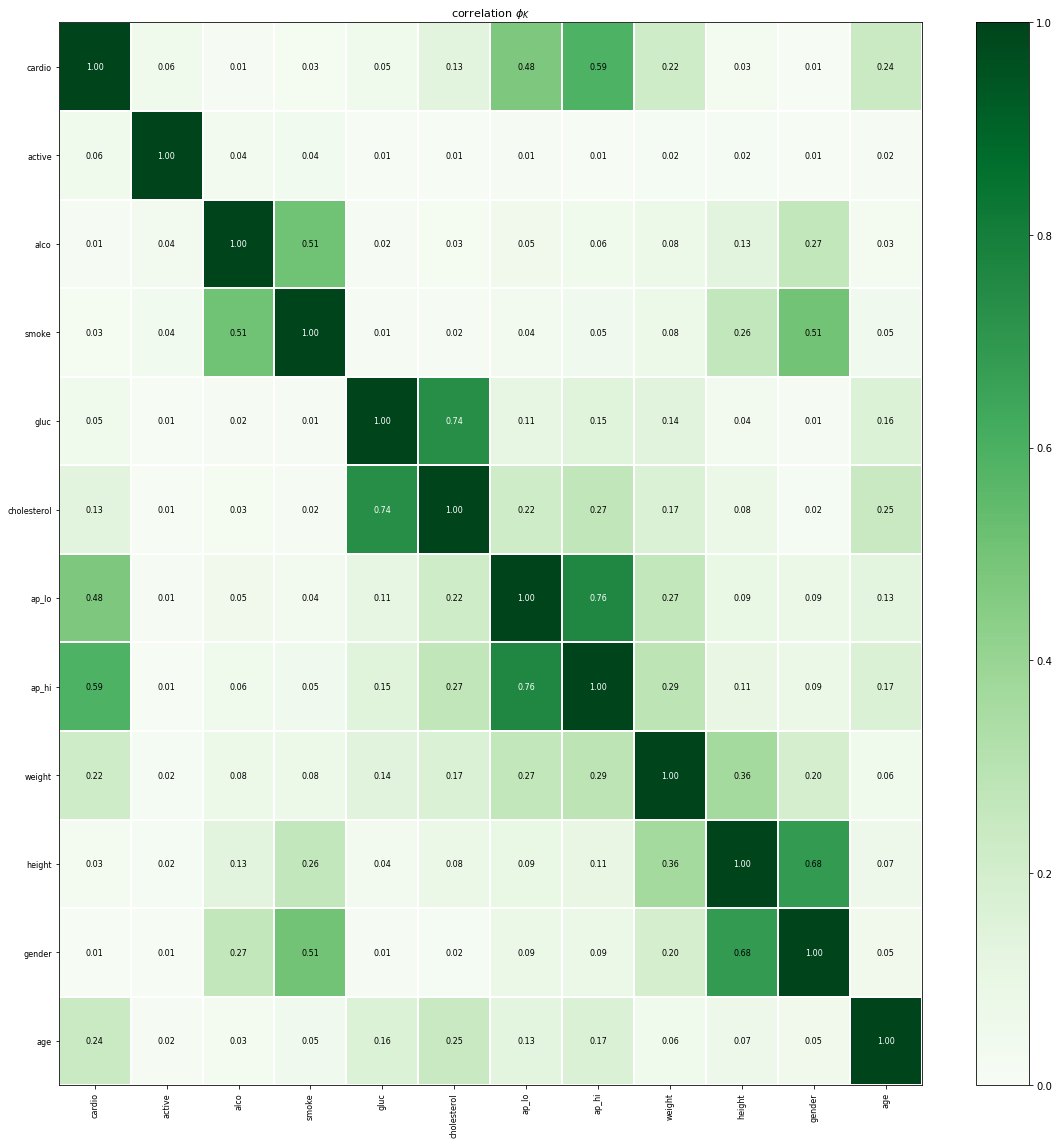

In [319]:
phik_overview = train.phik_matrix(interval_cols=None)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8,
                        figsize=(16, 16))
plt.tight_layout()

Мультиколлинеарность не обнаружена, можно приступать к подбору гиперпараметров

In [320]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67092 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          67092 non-null  float64
 1   gender       67092 non-null  int64  
 2   height       67092 non-null  int64  
 3   weight       67092 non-null  float64
 4   ap_hi        67092 non-null  int64  
 5   ap_lo        67092 non-null  int64  
 6   cholesterol  67092 non-null  int64  
 7   gluc         67092 non-null  int64  
 8   smoke        67092 non-null  int64  
 9   alco         67092 non-null  int64  
 10  active       67092 non-null  int64  
 11  cardio       67092 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.7 MB


# Подготовка признаков и выбор модели

In [341]:
def importance(model,features):
    imp = pd.Series(model.feature_importances_,index=features.columns).sort_values(ascending=False)
    ax = sns.barplot(x=imp,y=imp.index)
    ax.set(xlabel = 'Важность признаков',ylabel ='Признаки')
    return imp

In [321]:
train_df=train.copy()

In [322]:
features_train = train.drop(columns=['cardio'])
target_train = train['cardio']

In [323]:
features_train.shape,target_train.shape

((67092, 11), (67092,))

In [324]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Logistic Regression

In [327]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'height', 'weight',
                                                   'ap_hi', 'ap_lo']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['cholesterol', 'gluc',
                                                   'smoke', 'alco',
                                                   'active'])])),
                ('classifier', LogisticRegression())])

In [335]:
param_grid = {
    "classifier__C": [0.1, 1.0, 10, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=5,scoring='roc_auc')
grid_search.fit(features_train, target_train)
print("Best params:")
print(grid_search.best_params_)
print(f"Internal CV score: {grid_search.best_score_:.3f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "param_classifier__C",
    ]
].head(5)

Best params:
{'classifier__C': 10}
Internal CV score: 0.791


,mean_test_score,std_test_score,param_classifier__C
2,0.790712,0.005040,10
3,0.790712,0.005040,100
1,0.790711,0.005040,1
0,0.790701,0.005033,0.1


## CatBoost

In [340]:
train_dataset = cb.Pool(features_train,target_train, cat_features=categorical_features)
model = cb.CatBoostClassifier(iterations=1000,
                              loss_function='Logloss',
                              eval_metric='AUC',
                              logging_level='Silent',
                              random_seed=random_seed)

#Declare parameters to tune and values to try
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,]}

#Find optimum parameters
model.grid_search(grid,train_dataset,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8024586	best: 0.8024586 (0)	total: 38.2s	remaining: 10m 49s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8024188	best: 0.8024586 (0)	total: 1m 10s	remaining: 9m 25s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8026039	best: 0.8026039 (2)	total: 1m 42s	remaining: 8m 33s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8030846	best: 0.8030846 (3)	total: 2m 15s	remaining: 7m 53s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.8025068	best: 0.8030846 (3)	total: 

{'params': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [ ]:
# def objective_cat(trial):
#
#     params = {
#         'iterations':trial.suggest_int("iterations", 4000, 25000),
#         'od_wait':trial.suggest_int('od_wait', 500, 2300),
#         'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
#         'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
#         'subsample': trial.suggest_uniform('subsample',0,1),
#         'random_strength': trial.suggest_uniform('random_strength',10,50),
#         'depth': trial.suggest_int('depth',1, 15),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
#     }
#
#     model = cb.CatBoostClassifier(
#         loss_function="AUC",
#         random_state=random_seed,
#         **params,
#     )
#
#     return train_model_for_study(X, y, model)
# study_cat = optuna.create_study(direction="maximize")
# study_cat.optimize(objective_cat, n_trials=1)
# study_cat.best_params

# Feature Engineering

In [344]:
train_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0


Добавим пару новых фич

Индекс массы тела

In [351]:
def bmi(weight,height):
    bmi = weight/(height/100)**2
    if bmi <18.5:
        return 'underweight'
    elif 18.5 <= bmi <25:
        return 'norm'
    elif 25 <= bmi <30:
        return 'overweight'
    elif 30 <= bmi <35:
        return 'obesity 1'
    elif 35 <= bmi <40:
        return 'obesity 2'
    else:
        return 'obesity 3'

In [350]:
def blood_pressure(high,low):
    if low <=59 and high <=89:
        return 'hypo'
    elif low <=84 and high <=129:
        return 'norm'
    else:
        return 'hiper'

In [391]:
train_df['bmi'] = train_df.apply(lambda x: bmi(x['weight'], x['height']), axis=1)
train_df['blood_pressure'] = train_df.apply(lambda x: blood_pressure(x['ap_hi'], x['ap_lo']), axis=1)
features_test=test.copy()
features_test['bmi'] = features_test.apply(lambda x: bmi(x['weight'], x['height']), axis=1)
features_test['blood_pressure'] = features_test.apply(lambda x: blood_pressure(x['ap_hi'], x['ap_lo']), axis=1)

In [362]:
train_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,blood_pressure
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,norm,norm
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,obesity 1,hiper
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,norm,hiper
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,overweight,hiper
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,norm,norm


In [369]:
features_train=train_df.drop(columns=['cardio'])

In [370]:
categorical_features=['cholesterol', 'gluc', 'smoke', 'alco', 'active','bmi','blood_pressure']

In [371]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)
param_grid = {
    "classifier__C": [0.1, 1.0, 10, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=5,scoring='roc_auc')
grid_search.fit(features_train, target_train)
print("Best params:")
print(grid_search.best_params_)
print(f"Internal CV score: {grid_search.best_score_:.3f}")
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results[
    [
        "mean_test_score",
        "std_test_score",
        "param_classifier__C",
    ]
].head(5)

Best params:
{'classifier__C': 1.0}
Internal CV score: 0.790


,mean_test_score,std_test_score,param_classifier__C
1,0.790420,0.004796,1
0,0.790411,0.004779,0.1
2,0.790409,0.004808,10
3,0.790409,0.004814,100


In [372]:
train_dataset = cb.Pool(features_train,target_train, cat_features=categorical_features)
model = cb.CatBoostClassifier(iterations=1000,
                              loss_function='Logloss',
                              eval_metric='AUC',
                              logging_level='Silent',
                              random_seed=random_seed)

#Declare parameters to tune and values to try
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,]}

#Find optimum parameters
model.grid_search(grid,train_dataset,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8025579	best: 0.8025579 (0)	total: 49.1s	remaining: 13m 54s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8029239	best: 0.8029239 (1)	total: 1m 30s	remaining: 12m 5s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8026064	best: 0.8029239 (1)	total: 2m 3s	remaining: 10m 16s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8027983	best: 0.8029239 (1)	total: 2m 40s	remaining: 9m 20s
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
4:	loss: 0.8026432	best: 0.8029239 (1)	total: 

{'params': {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [393]:
features_test=features_test.drop(columns='id')

In [394]:
pred_proba_test = model.predict_proba(features_test)[:, 1]
pred_proba_test

array([0.65755733, 0.70570151, 0.66019173, ..., 0.70013374, 0.73600944,
       0.84604203])

In [396]:
predicted_test = model.predict(features_test)
predicted_test

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)